Loading model from: results/results_L1_Adam_lr0.001_0.96_5_3/LeNet300_OutputOnly/model/checkpoint_epoch_10.pth
Loading model from: results/results_L1_Adam_lr0.001_0.96_5_3/LeNet300_OutputOnly/model/checkpoint_epoch_15.pth
Loading model from: results/results_L1_Adam_lr0.001_0.96_5_3/LeNet300_OutputOnly/model/checkpoint_epoch_20.pth
Loading model from: results/results_L1_Adam_lr0.001_0.96_5_3/LeNet300_OutputOnly/model/checkpoint_epoch_25.pth
Loading model from: results/results_L1_Adam_lr0.001_0.96_5_3/LeNet300_OutputOnly/model/checkpoint_epoch_30.pth
Loading model from: results/results_L1_Adam_lr0.001_0.96_5_3/LeNet300_OutputOnly/model/checkpoint_epoch_35.pth
Loading model from: results/results_L1_Adam_lr0.001_0.96_5_3/LeNet300_OutputOnly/model/checkpoint_epoch_40.pth
Loading model from: results/results_L1_Adam_lr0.001_0.96_5_3/LeNet300_OutputOnly/model/checkpoint_epoch_45.pth
Loading model from: results/results_L1_Adam_lr0.001_0.96_5_3/LeNet300_OutputOnly/model/checkpoint_epoch_5.pth
Lo

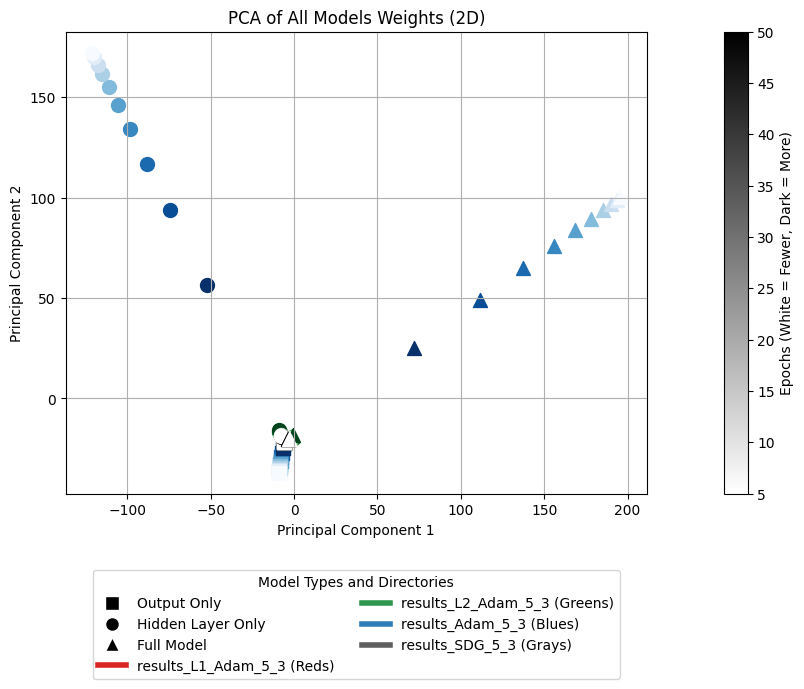

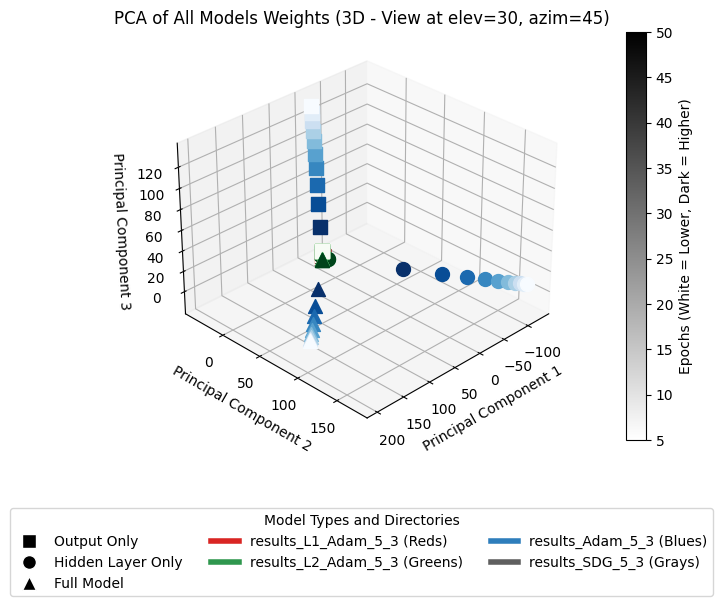

Interactive 3D plot exported to saved_plots/pca_models_weights_3d_plot.html


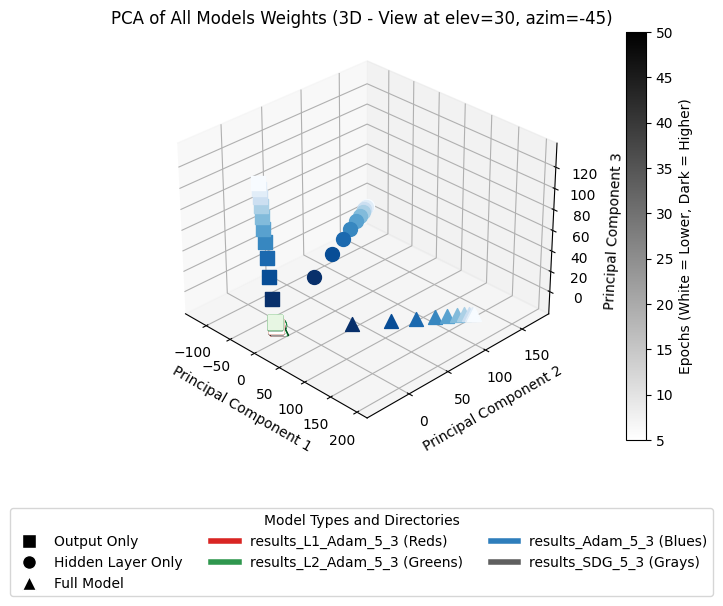

Interactive 3D plot exported to saved_plots/pca_models_weights_3d_plot.html


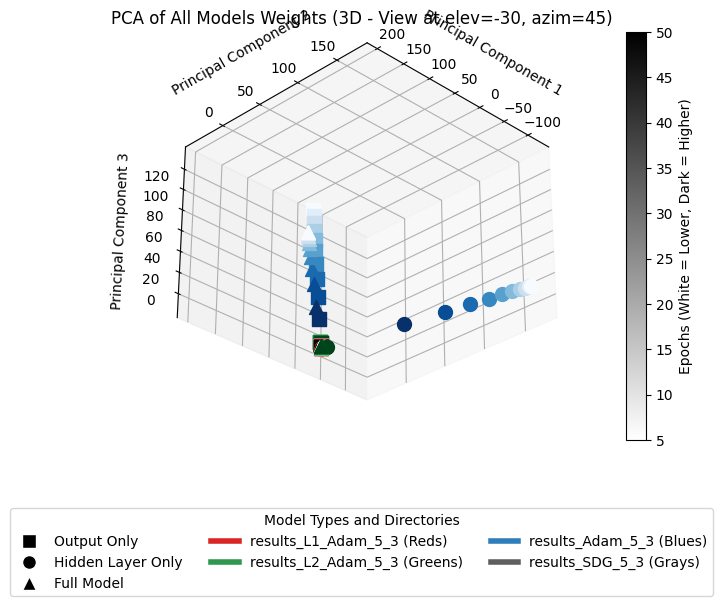

Interactive 3D plot exported to saved_plots/pca_models_weights_3d_plot.html


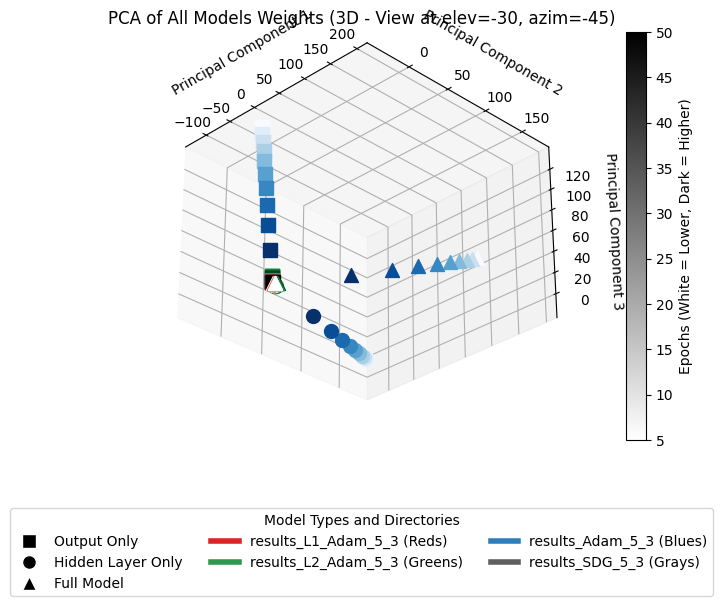

Interactive 3D plot exported to saved_plots/pca_models_weights_3d_plot.html


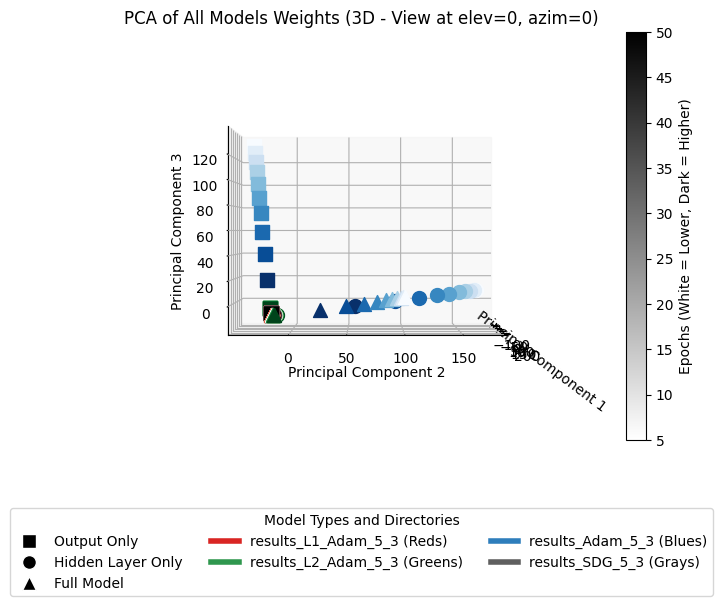

Interactive 3D plot exported to saved_plots/pca_models_weights_3d_plot.html


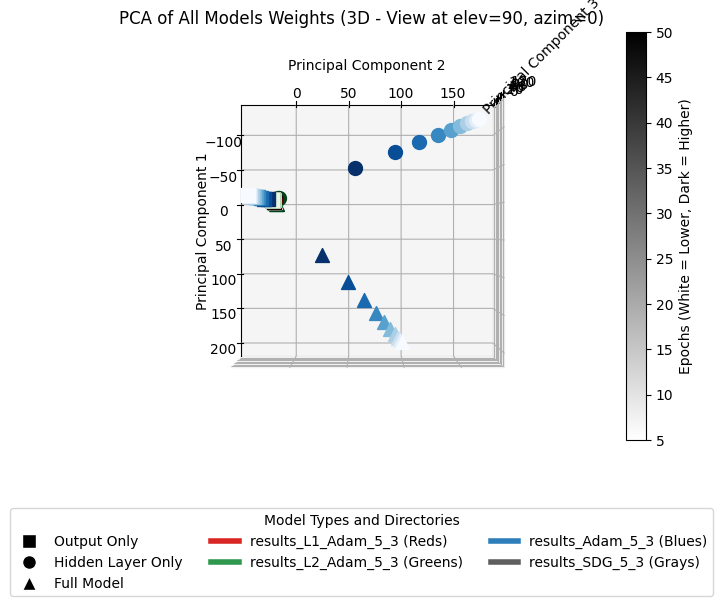

Interactive 3D plot exported to saved_plots/pca_models_weights_3d_plot.html
PCA results exported to saved_plots/pca_models_weights.csv


In [16]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.decomposition import PCA
import glob
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
import plotly.graph_objects as go
import plotly.io as pio

# Assuming the KANLinearFullyConnected import
from architectures_28x28.KANLinearFullyConnected import KANLinearFullyConnected

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LeNet300_OutputOnly(nn.Module):
    """LeNet-300 model with only output layer."""
    def __init__(self,  grid_size, spline_order):
        super(LeNet300_OutputOnly, self).__init__()
        layers_hidden = [784, 10]  # Only input layer and output layer
        self.fc = KANLinearFullyConnected(layers_hidden, grid_size = grid_size, spline_order = spline_order)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the MNIST image (28x28 -> 784)
        x = F.log_softmax(self.fc.layers[0](x), dim=1)  # Output layer (784 -> 10)
        return x

class LeNet300_HiddenLayerOnly(nn.Module):
    """LeNet-300 model with only the 300 hidden layer and output layer."""
    def __init__(self, grid_size, spline_order):
        super(LeNet300_HiddenLayerOnly, self).__init__()
        layers_hidden = [784, 300, 10]  # Input layer -> 300 hidden layer -> Output layer
        self.fc = KANLinearFullyConnected(layers_hidden, grid_size = grid_size, spline_order = spline_order)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the MNIST image (28x28 -> 784)
        x = F.relu(self.fc.layers[0](x))  # First KANLinear layer (784 -> 300)
        x = F.log_softmax(self.fc.layers[1](x), dim=1)  # Output layer (300 -> 10)
        return x

class LeNet300_Full(nn.Module):
    """Full LeNet-300-100 model."""
    def __init__(self,  grid_size, spline_order):
        super(LeNet300_Full, self).__init__()
        layers_hidden = [784, 300, 100, 10]  # Full architecture
        self.fc = KANLinearFullyConnected(layers_hidden, grid_size = grid_size, spline_order = spline_order)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the MNIST image (28x28 -> 784)
        x = F.relu(self.fc.layers[0](x))  # First KANLinear layer (784 -> 300)
        x = F.relu(self.fc.layers[1](x))  # Second KANLinear layer (300 -> 100)
        x = F.log_softmax(self.fc.layers[2](x), dim=1)  # Output layer (100 -> 10)
        return x


# Function to extract weights from a model
def extract_weights(model):
    weights = []
    for name, param in model.named_parameters():
        if 'weight' in name:
            weights.append(param.detach().cpu().numpy().flatten())
    return np.concatenate(weights)

# Function to pad weights with zeros to match the largest model
def pad_weights_to_max_size(weights, max_size):
    current_size = weights.shape[0]
    if current_size < max_size:
        padding = np.zeros(max_size - current_size)
        weights = np.concatenate([weights, padding])
    return weights

# Function to generate colors for each directory and epoch (keeping colors distinct and hue for epochs)
def get_color_map_for_directory(directory, epochs, cmap_name):
    norm = Normalize(vmin=min(epochs), vmax=max(epochs))
    cmap = cm.get_cmap(cmap_name)
    return [cmap(1 - norm(epoch)) for epoch in epochs]  # Reverse the gradient (1 - norm)

# Load models once, extract weights, and reuse the weights
def load_models_and_extract_weights_once(directories, model_types):
    all_weights = []
    all_epochs = []
    all_labels = []
    max_size = 0

    # Dictionary to store all models and epochs across the 4 directories
    models_dict = {}

    # Iterate over each directory and model type
    for directory in directories:
        for model_name, model_class in model_types.items():
            model_dir = os.path.join(directory, model_name, 'model')
            model_paths = sorted(glob.glob(os.path.join(model_dir, '*.pth')))

            # Debugging: Print the model paths to ensure they exist
            if not model_paths:
                print(f"No model files found in {model_dir}")
                continue  # Skip if no models found

            models = []
            epochs = []

            number_of_points = 5
            spline_order = 3
            # Load models and extract weights
            for path in model_paths:
                print(f"Loading model from: {path}")  # Debugging: Print the path of the model being loaded
                model = model_class(number_of_points, spline_order).to(device)
                checkpoint = torch.load(path, map_location=device)
                model.load_state_dict(checkpoint['model_state_dict'])
                epoch = checkpoint['epoch']

                # Extract weights once
                weights = extract_weights(model)
                max_size = max(max_size, weights.shape[0])  # Find the maximum size for padding

                all_weights.append(weights)
                all_epochs.append(epoch)
                all_labels.append(f"{directory}_{model_name}")
                models.append(model)
                epochs.append(epoch)

            # Store models and epochs for the directory and model type
            models_dict[f"{directory}_{model_name}"] = (models, epochs)

    # If no weights were loaded, raise an error
    if not all_weights:
        raise ValueError("No weights were loaded from the models. Check if the model paths are correct and contain valid .pth files.")

    # Pad weights to the maximum size
    padded_weights = [pad_weights_to_max_size(weights, max_size) for weights in all_weights]

    return np.stack(padded_weights), np.array(all_epochs), all_labels, models_dict


# Main function to perform PCA and create all plots and exports
def plot_weights_pca_and_export_combined(all_weights, all_epochs, all_labels, models_dict):
    # Create a folder to save the plots
    save_folder = "saved_plots"
    os.makedirs(save_folder, exist_ok=True)

    # Apply PCA
    pca = PCA(n_components=3)
    weights_pca = pca.fit_transform(all_weights)

    weights_pca_2d = weights_pca[:, :2]
    weights_pca_3d = weights_pca

    # Define colormaps for directories
    directory_colormaps = {
        'results/results_L1_Adam_lr0.001_0.96_5_3': 'Reds',
        'results/results_L2_Adam_lr0.001_0.96_5_3': 'Greens',
        'results/results_none_Adam_lr0.001_0.96_5_3': 'Blues',
        'results/results_none_SGD_lr0.01_5_3': 'Greys'
    }

    # Shapes for different network types
    shapes = {'LeNet300_OutputOnly': 's', 'LeNet300_HiddenLayerOnly': 'o', 'LeNet300_Full': '^'}

    fig, ax_scatter = plt.subplots(figsize=(10, 6))

    # Iterate over the models and plot them with colors for directory and hue for epochs
    for i, label in enumerate(all_labels):
        # Dynamically extract the correct directory by finding the match within the known directory_colormaps keys
        directory = None
        for known_directory in directory_colormaps.keys():
            if known_directory in label:
                directory = known_directory
                break

        if directory is None:
            raise KeyError(f"Could not find a matching directory in the label: {label}")

        model_type = '_'.join(label.split('_')[-2:])  # Extract model type (e.g., 'LeNet300_OutputOnly')
        
        cmap_name = directory_colormaps[directory]  # Get colormap based on directory
        colors = get_color_map_for_directory(directory, all_epochs, cmap_name)  # Color by epoch for each directory

        ax_scatter.scatter(weights_pca_2d[i, 0], weights_pca_2d[i, 1], color=colors[i], marker=shapes[model_type], s=100)

    # Create a reversed color bar for the epochs (white for low epochs, dark for high)
    norm = Normalize(vmin=min(all_epochs), vmax=max(all_epochs))
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('gray_r'))  # 'gray_r' reverses the grayscale gradient
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax_scatter, orientation="vertical", pad=0.1)
    cbar.set_label('Epochs (White = Fewer, Dark = More)')

    # Custom legends for shapes (model types)
    shape_legend = [Line2D([0], [0], marker=shape, color='w', label=name, markerfacecolor='black', markersize=10)
                    for shape, name in zip(['s', 'o', '^'], ['Output Only', 'Hidden Layer Only', 'Full Model'])]

    # Custom legends for colors (directories)
    color_legend = [
        Line2D([0], [0], color=cm.get_cmap('Reds')(0.7), lw=4, label='results_L1_Adam_5_3 (Reds)'),
        Line2D([0], [0], color=cm.get_cmap('Greens')(0.7), lw=4, label='results_L2_Adam_5_3 (Greens)'),
        Line2D([0], [0], color=cm.get_cmap('Blues')(0.7), lw=4, label='results_Adam_5_3 (Blues)'),
        Line2D([0], [0], color=cm.get_cmap('Greys')(0.7), lw=4, label='results_SDG_5_3 (Grays)')
    ]

    # Combine legends for shapes and colors
    plt.legend(handles=shape_legend + color_legend, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, title='Model Types and Directories')

    # Set plot titles and labels
    ax_scatter.set_title('PCA of All Models Weights (2D)')
    ax_scatter.set_xlabel('Principal Component 1')
    ax_scatter.set_ylabel('Principal Component 2')
    ax_scatter.grid(True)

    # Save 2D PCA plot before showing
    plt.savefig(os.path.join(save_folder, "PCA_2D_plot.png"))
    plt.show()

    # 3D Matplotlib plot with views from different sides of the cube
    angles = [(30, 45), (30, -45), (-30, 45), (-30, -45), (0, 0), (90, 0)]
    
    for elev, azim in angles:
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111, projection='3d')
        
        # Set the elevation and azimuth angles for the current plot
        ax.view_init(elev=elev, azim=azim)
        
        for i, label in enumerate(all_labels):
            directory = None
            for known_directory in directory_colormaps.keys():
                if known_directory in label:
                    directory = known_directory
                    break
    
            if directory is None:
                raise KeyError(f"Could not find a matching directory in the label: {label}")
    
            model_type = '_'.join(label.split('_')[-2:])
            cmap_name = directory_colormaps[directory]
            colors = get_color_map_for_directory(directory, all_epochs, cmap_name)
    
            ax.scatter(weights_pca_3d[i, 0], weights_pca_3d[i, 1], weights_pca_3d[i, 2], 
                       color=colors[i], marker=shapes[model_type], s=100)
    
        # Add the colorbar and legend for each 3D plot
        fig.subplots_adjust(left=0.25, right=0.85, bottom=0.2)  # Adjust plot to leave space at the bottom for the legend
        sm = plt.cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('gray_r'))
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, orientation="vertical", pad=0.1)
        cbar.set_label('Epochs (White = Lower, Dark = Higher)')
    
        # Place the legend below the plot
        plt.legend(
            handles=shape_legend + color_legend, 
            loc='upper center', 
            bbox_to_anchor=(0.5, -0.15),  # Move legend below the plot
            ncol=3,  # Spread legend entries across multiple columns
            title='Model Types and Directories'
        )
    
        ax.set_title(f'PCA of All Models Weights (3D - View at elev={elev}, azim={azim})')
        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')
        ax.set_zlabel('Principal Component 3')

        # Save the 3D plot with the specific elevation and azimuth values
        plt.savefig(os.path.join(save_folder, f"PCA_3D_plot_elev_{elev}_azim_{azim}.png"))
        plt.show()
        
        # 3D Interactive Plotly plot
        fig = go.Figure()
        
        for i, label in enumerate(all_labels):
            directory = None
            for known_directory in directory_colormaps.keys():
                if known_directory in label:
                    directory = known_directory
                    break
        
            if directory is None:
                raise KeyError(f"Could not find a matching directory in the label: {label}")
        
            model_type = '_'.join(label.split('_')[-2:])
            cmap_name = directory_colormaps[directory]
            colors = get_color_map_for_directory(directory, all_epochs, cmap_name)
        
            rgba_color = colors[i]
            fig.add_trace(go.Scatter3d(
                x=[weights_pca_3d[i, 0]],
                y=[weights_pca_3d[i, 1]],
                z=[weights_pca_3d[i, 2]],
                mode='markers',
                marker=dict(
                    size=8,
                    color=f'rgba({int(rgba_color[0] * 255)}, {int(rgba_color[1] * 255)}, {int(rgba_color[2] * 255)}, {rgba_color[3]})', 
                    opacity=0.8
                ),
                name=f'{label} (Epoch {all_epochs[i]})'
            ))
        
        # Update layout to set the size of the plot and move the legend below the plot
        fig.update_layout(
            title='Interactive PCA of All Models Weights (3D)',
            scene=dict(
                xaxis_title='Principal Component 1',
                yaxis_title='Principal Component 2',
                zaxis_title='Principal Component 3',
            ),
            legend=dict(
                orientation="v",  # Horizontal legend
                yanchor="top",
                y=1,  # Move the legend below the plot
                xanchor="right",
                x=7.5
            ),
            width=1000,  # Set plot width to 1000
            height=1000  # Set plot height to 1000
        )
        
        # Export the 3D interactive plot to HTML
        export_path_html = os.path.join(save_folder, "pca_models_weights_3d_plot.html")
        pio.write_html(fig, export_path_html)
        print(f"Interactive 3D plot exported to {export_path_html}")

    

    # Export results to CSV
    df = pd.DataFrame(weights_pca_3d, columns=['PC1', 'PC2', 'PC3'])
    df['Epoch'] = all_epochs
    df['Model'] = all_labels
    export_path_csv = os.path.join(save_folder, "pca_models_weights.csv")
    df.to_csv(export_path_csv, index=False)
    print(f"PCA results exported to {export_path_csv}")

# Load models only once for all operations with the new directories
directories = [
    'results/results_L1_Adam_lr0.001_0.96_5_3',
    'results/results_L2_Adam_lr0.001_0.96_5_3',
    'results/results_none_Adam_lr0.001_0.96_5_3',
    'results/results_none_SGD_lr0.01_5_3'
]

model_types = {
    'LeNet300_OutputOnly': LeNet300_OutputOnly,
    'LeNet300_HiddenLayerOnly': LeNet300_HiddenLayerOnly,
    'LeNet300_Full': LeNet300_Full
}
# Load models once and reuse
all_weights, all_epochs, all_labels, models_dict = load_models_and_extract_weights_once(directories, model_types)

# Perform PCA, plot weights, and export
plot_weights_pca_and_export_combined(all_weights, all_epochs, all_labels, models_dict)
